# **Model Evaluation**

**Goal** <br>
Load the weights from a trained model to create a function capable of making predcitions on synthetic data.

# **Import Statements**

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib, scipy
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from scipy.signal import find_peaks
from google.colab import files


print("Tensorflow Version: " +  tf.__version__)
print("Numpy Version: "  + np.__version__)
print("Matplotlib Version: " + matplotlib.__version__)
print("Scipy Version: " + scipy.__version__)

Tensorflow Version: 2.9.2
Numpy Version: 1.21.6
Matplotlib Version: 3.2.2
Scipy Version: 1.7.3


# **Synthetic Data Generation**

**Loading Data**

In [3]:
datadir  = '/content/drive/MyDrive/Coursework/Research/Mazin Lab/ML Pulse Analysis for MKIDs/' #this line is the filepath in my personal google drive

def plotPulse(I,Q,I_trace,Q_trace):
  plt.plot(I,Q)
  plt.title('I Q data')
  plt.show()
  plt.title('I Q trace data')
  plt.scatter(I_trace,Q_trace,s=0.25,c='red')

# Load sweep data
sweep = np.load(datadir+'sweep.npz')
f = sweep['f']
z = sweep['z']
I = z.real
Q = z.imag


# Load all wavelengths
fnames = ['808nm.npz','920nm.npz','980nm.npz','1120nm.npz','1310nm.npz']
i_trace = []
q_trace = []
peak_heights = []
peak_indices = []
filtered_data = []
for i in range(5):
    data = np.load(datadir+fnames[i])
    i_trace.append(data['i_trace'])
    q_trace.append(data['q_trace'])
    filtered_data.append(data['filtered_data'])
    peak_heights.append(data['peak_heights'])
    peak_indices.append(data['peak_indices'])
    data_size = data['i_trace'][:,0].size

i_trace = np.array(i_trace)
q_trace = np.array(q_trace)
filtered_data = np.array(filtered_data)

# Create Fake Data Stream
SampRate = 2000000       # Sample rate is 2 MHz
TrainingTime = 0.01      # Training data set length in sec
PhotonRate = 1000.0      # Photon Arrival rate in photons/sec
N_time_datapoints = int(SampRate*TrainingTime) #Number of datapoints based on the training time and sample rate
photon_prob = PhotonRate/SampRate #The probability that a photon is incident at a given time_datapoint


i_train=np.zeros(N_time_datapoints)
q_train=np.zeros(N_time_datapoints)
label=np.zeros(N_time_datapoints)
peaks=np.zeros(N_time_datapoints,dtype=int)
time = np.linspace(0,TrainingTime,N_time_datapoints)



**Mapping Function + Data Visualization**

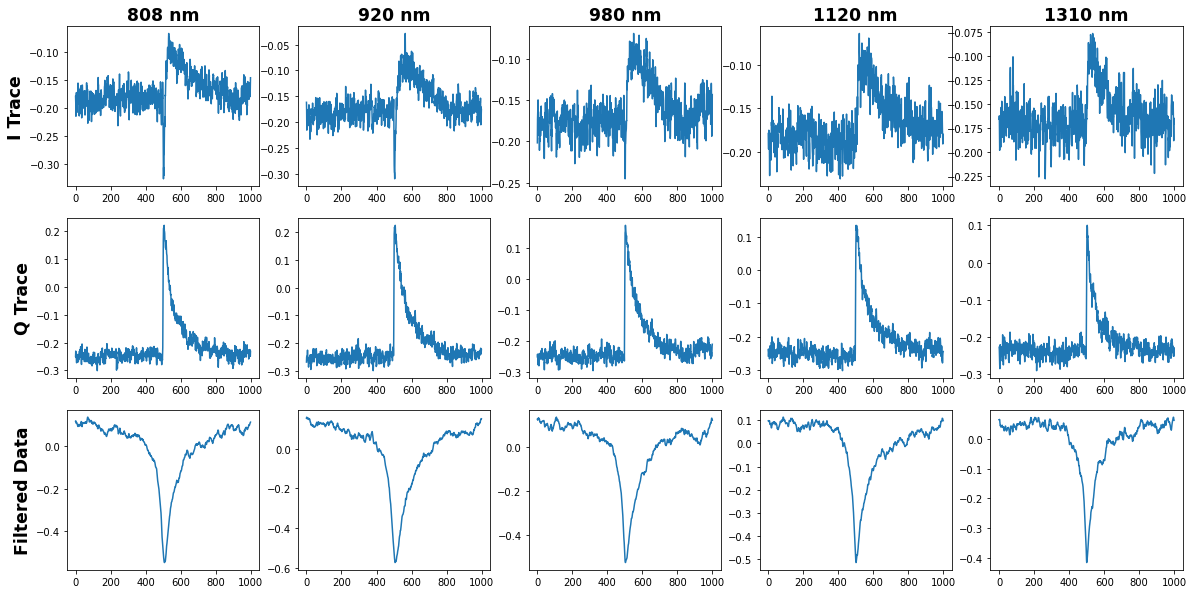

In [4]:
def mapping(i_trace, q_trace, n_pts):
    #unravel the data to get an array of 50,000 first values, and 50,000 last values
    first_val_i = i_trace[:,:,0].ravel()
    last_val_i = i_trace[:,:,n_pts].ravel()

    first_val_q  = q_trace[:,:,0].ravel()
    last_val_q = q_trace[:,:,n_pts].ravel()
    
    seed_mapping = []
    pulse_mapping = []
    for i in range(len(first_val_i)):
        comparison = np.abs(last_val_i - first_val_i[i])**2 + np.abs(last_val_q - first_val_q[i])**2 #determine least squares i/q channel comparison
        index = np.where(comparison == min(comparison)) #now index is a list of number(s) between 0 and 49,999 
        index = np.array(index).ravel() #takes array nestled within list and turns it into a 2d array, then unravels it into a 1D array
        
        #if there are multiple indices which satisfy the least squares comparison, select one at random. Ensure index is typecast from tuple to int
        if len(index) > 1:
          choice = np.random.randint(0,len(index))
          index = int(index[choice])
        else:
          index = int(index)
        

        seed = index//10000 #determines the seed index(an integer between 0 and 4) from the index through floor division
        pulse = index - seed*10000 #determines the pulse index(an integer between 0 and 9,999) by subtracting previous seed's pulses
        
        seed_mapping.append(seed)
        pulse_mapping.append(pulse)
    
    return seed_mapping, pulse_mapping

#Given a seed and pulse number, returns the index within the mapping array that corresponds to that seed/pulse
def index_to_mapping(seed, pulse):
    mapping = seed*10000 + pulse
    return mapping
  
  
#Plot first pulse in i_trace, q_trace, and filtered_data for each provided wavelength 
t = np.arange(1000) #get time axis in terms of number of points to see what a reasonable estimate for n_pts is
fig, ax = plt.subplots(3,5, figsize = (20,10))
row = ["I Trace","Q Trace","Filtered Data"]
col = ['808 nm','920 nm','980 nm','1120 nm','1310 nm']
for i in range(3):
  ax[i,0].set_ylabel(row[i], rotation = 90, fontweight = "bold", size = 'xx-large')
for i in range(5):
  ax[0,i].plot(t, i_trace[i,0,:])
  ax[1,i].plot(t, q_trace[i,0,:])
  ax[2,i].plot(t, filtered_data[i,0,:])
  ax[0,i].set_title(col[i], fontweight = "bold", size = 'xx-large')
  




**Generating Mapping**

In [5]:
n_pts = 100
seed_mapping, pulse_mapping = mapping(i_trace, q_trace, n_pts)

Generating the least squares mapping and loading the data takes around ~3 minutes, so it is it's own cell.

**Baselevel Noise Generation** <br>
This cell overwrites the arrays of zero with a noise spectrum generated by stitching together the first `n_pts` of noise from the peak data

In [6]:
#creating base level noise in i_trace, q_trace, and label from pulse data/mapping
pos = 0
pulse = np.random.randint(data_size) #choose a random pulse for a given wavelength
seed = np.random.randint(0,4) #choose a random wavelength of light to include from 5 files
while pos <= N_time_datapoints - n_pts:
    index = index_to_mapping(seed, pulse)
    i_train[pos:pos+n_pts] = i_trace[seed_mapping[index], pulse_mapping[index], 0:n_pts]
    q_train[pos:pos+n_pts] = q_trace[seed_mapping[index], pulse_mapping[index], 0:n_pts]
    pulse = pulse_mapping[index]
    seed = seed_mapping[index]
    pos += n_pts


**Noise and Power Spectral Density Visualization**

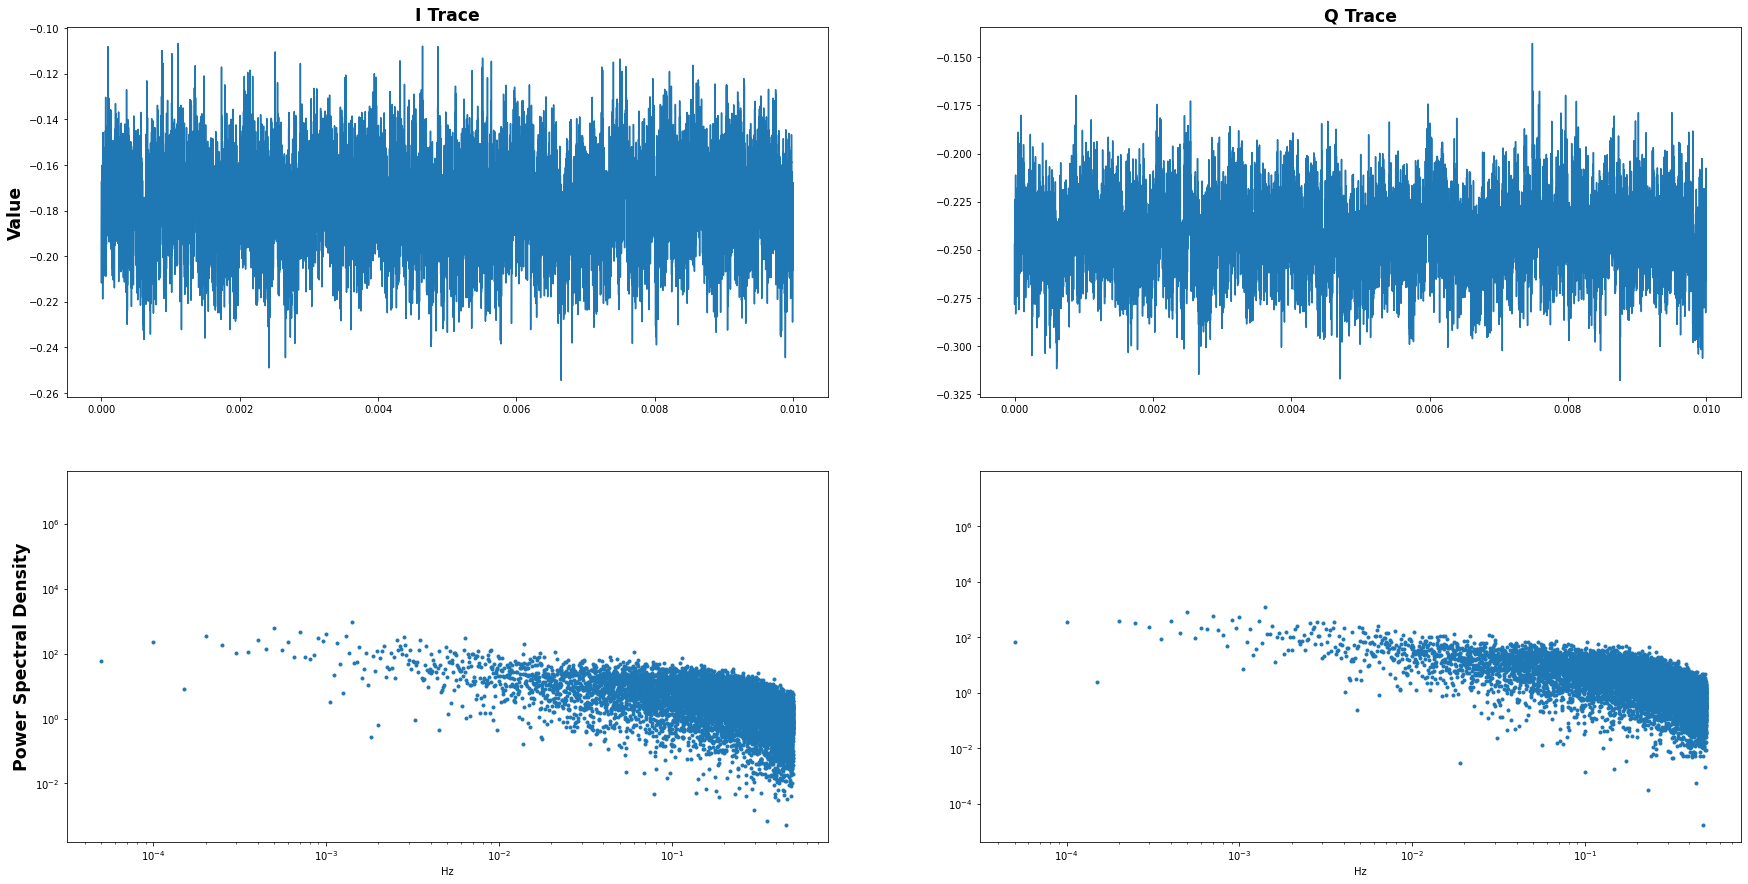

In [7]:
fig, ax = plt.subplots(2,2,figsize = (30,15))

#Fourier Transform stuff
freq = np.fft.fftfreq(len(time))
powerspec_i = np.abs(np.fft.fft(i_train))**2
powerspec_q = np.abs(np.fft.fft(q_train))**2



#Row labels
ax[0,0].set_ylabel("Value",fontweight = "bold",size = 'xx-large', rotation = 90)
ax[1,0].set_ylabel("Power Spectral Density",fontweight = "bold",size = 'xx-large', rotation = 90)

#Column labels
ax[0,0].set_title("I Trace",fontweight = "bold", size = 'xx-large')
ax[0,1].set_title("Q Trace",fontweight = "bold", size = 'xx-large')


#x_label + x_lims
for i in range(2):
  for j in range(2):
    ax[1,j].set_xlabel("Hz")
    #ax[1,j].set_xlim(left=0,right =0.5)
    
    

#I_trace
ax[0,0].plot(time, i_train)
ax[1,0].loglog(freq,powerspec_i,linestyle = '', marker = '.')


#Q_trace
ax[0,1].plot(time, q_train)
ax[1,1].loglog(freq,powerspec_q, linestyle = '', marker = '.')


plt.show()

**Synthetic Data Generation**<br>
This cell redoes the noise generation from earlier, but now at each discrete time step has a probability of `photon_prob` to insert a photon detection.


In [8]:
'''
Function that takes an initial value in i, q, and label and returns the seed and pulse indices of the dataset closest to those initial values
'''
def insert_index(i_insertion_val,q_insertion_val,i_trace,q_trace, peak_indices,halfwidth,insert_peak=bool):
        '''
        Generate first_vals_i, first_vals_q, and first_vals_label if inserting noise
        '''
        if insert_peak == False:
          first_vals_i = i_trace[:,:,0].ravel()
          first_vals_q = q_trace[:,:,0].ravel()
          #generate comparison
          comparison = np.abs(first_vals_i - i_insertion_val)**2 + np.abs(first_vals_q - q_insertion_val)**2

        '''
        Generate first_vals_i, first_vals_q, and first_vals_label if inserting a peak
        '''
        if insert_peak == True: 
          peak_start_val_i = []
          peak_start_val_q = []

          #shape(i_trace)[0] is number of wavelengths, shape(i_trace)[1] is number of pulses in a given wavelength dataset
          for i in range(np.shape(i_trace)[0]):  
            for j in range(np.shape(i_trace)[1]):
              val_i = i_trace[i,j,peak_indices[i][j] - halfwidth]
              val_q = q_trace[i,j,peak_indices[i][j] - halfwidth]
              
              peak_start_val_i.append(val_i)
              peak_start_val_q.append(val_q)
          
          #generate comparison
          comparison = np.abs(peak_start_val_i - i_insertion_val)**2 + np.abs(peak_start_val_q - q_insertion_val)**2 

        '''
        Figure out the index that minimizes the generated comparison
        '''
        
        index = np.where(comparison == min(comparison)) #now index is a list of number(s) between 0 and 49,999 
        index = np.array(index).ravel() #takes array nestled within list and turns it into a 2d array, then unravels it into a 1D array

        #if there are multiple indices which satisfy the least squares comparison, select one at random. Ensure index is typecast from tuple to int
        if len(index) > 1:
          choice = np.random.randint(0,len(index))
          index = int(index[choice])
        else:
          index = int(index)
        
        seed = index//10000 #determines the seed index(an integer between 0 and 4) from the index through floor division
        pulse = index - seed*10000 #determines the pulse index(an integer between 0 and 9,999) by subtracting previous seed's pulses

        return seed, pulse


'''
Function that Generates Synthetic Data with or without labels
'''
def synthetic_data_gen(i_trace,q_trace, filtered_data, peak_indices, SampRate, TrainingTime, PhotonRate, n_pts, pulse_halfwidth,return_labels=bool):
    #Uses SampRate, TrainingTime, and PhotonRate to generate N_time_datapoints and photon_prob
    N_time_datapoints = int(SampRate*TrainingTime) #Number of datapoints based on the training time and sample rate
    photon_prob = PhotonRate/SampRate #The probability that a photon is incident at a given time_datapoint

    
    #Initializing arrays to return
    photon_energy = np.zeros(N_time_datapoints)
    prob_incident = np.zeros(N_time_datapoints)
    i_train = np.zeros(N_time_datapoints)
    q_train = np.zeros(N_time_datapoints)

    #randomly initializing pulse and seed
    pos = 0
    pulse = np.random.randint(data_size) #choose a random pulse for a given wavelength
    seed = np.random.randint(0,4) #choose a random wavelength of light to include from 5 files
    while pos <= N_time_datapoints - n_pts:
        #If not inserting peak, continue stitching together noise
        index = index_to_mapping(seed, pulse)
        i_train[pos:pos+n_pts] = i_trace[seed_mapping[index], pulse_mapping[index], 0:n_pts]
        q_train[pos:pos+n_pts] = q_trace[seed_mapping[index], pulse_mapping[index], 0:n_pts]
        pulse = pulse_mapping[index]
        seed = seed_mapping[index]
        pos += n_pts
        
        #Generates a random number drawn from a uniform distribution over [0,1) and if it's less than or equal to the probability, insert a peak. It also ensures there is enough space left in the generated data to insert a pulse 
        if np.random.rand() <= photon_prob*n_pts and pos <= N_time_datapoints - pulse_halfwidth*2: 
            #finding insertion values
            i_insertion_val = i_train[pos-1]
            q_insertion_val = q_train[pos-1]
    
            #finding seed and pulse insert index for peak insertion
            peak_seed, peak_pulse = insert_index(i_insertion_val, q_insertion_val, i_trace, q_trace, peak_indices, pulse_halfwidth, insert_peak = True)

            #Error checking to ensure pulse is sufficiently centered to grab a full halfwidth on either side of it. If it fails this check, returns to the beginning of the loop and does not place a pulse
            pmax = peak_indices[peak_seed][peak_pulse]
            if pmax < pulse_halfwidth or pmax > np.shape(i_trace)[2] - pulse_halfwidth:
                continue

            #inserting peak
            i_train[pos:pos+pulse_halfwidth*2] = i_trace[peak_seed, peak_pulse, pmax-pulse_halfwidth:pmax + pulse_halfwidth]
            q_train[pos:pos+pulse_halfwidth*2] = q_trace[peak_seed, peak_pulse, pmax-pulse_halfwidth:pmax + pulse_halfwidth]
            photon_energy[pos+pulse_halfwidth] = filtered_data[peak_seed, peak_pulse, pmax] #insert the peak amplitude into the label and nothing else
            prob_incident[pos+pulse_halfwidth] = 1
            pos += pulse_halfwidth*2

            #function parameters for inserting data on the other side of the peak
            i_insertion_val = i_train[pos-1]
            q_insertion_val = q_train[pos-1]

            #find seed and pulse with smallest discontinuity on the peak's tail for insertion of subsequent data
            seed, pulse = insert_index(i_insertion_val, q_insertion_val, i_trace, q_trace, peak_indices, pulse_halfwidth, insert_peak = False)

            continue

    if return_labels == True:
        label = prob_incident, photon_energy
        return i_train, q_train, label
    elif return_labels == False:
        return i_train, q_train

'''
Generating Synthetic Data Using the Functions defined above
'''
#generating training data
pulse_halfwidth = 400
i_train, q_train, label = synthetic_data_gen(i_trace,q_trace, filtered_data, peak_indices, SampRate, TrainingTime, PhotonRate, n_pts, pulse_halfwidth,return_labels=True)

#Save the training data
np.savez('training.npz',I=i_train,Q=q_train,label=label,time = time)


**Synthetic Data and Power Spectral Density Visualization**

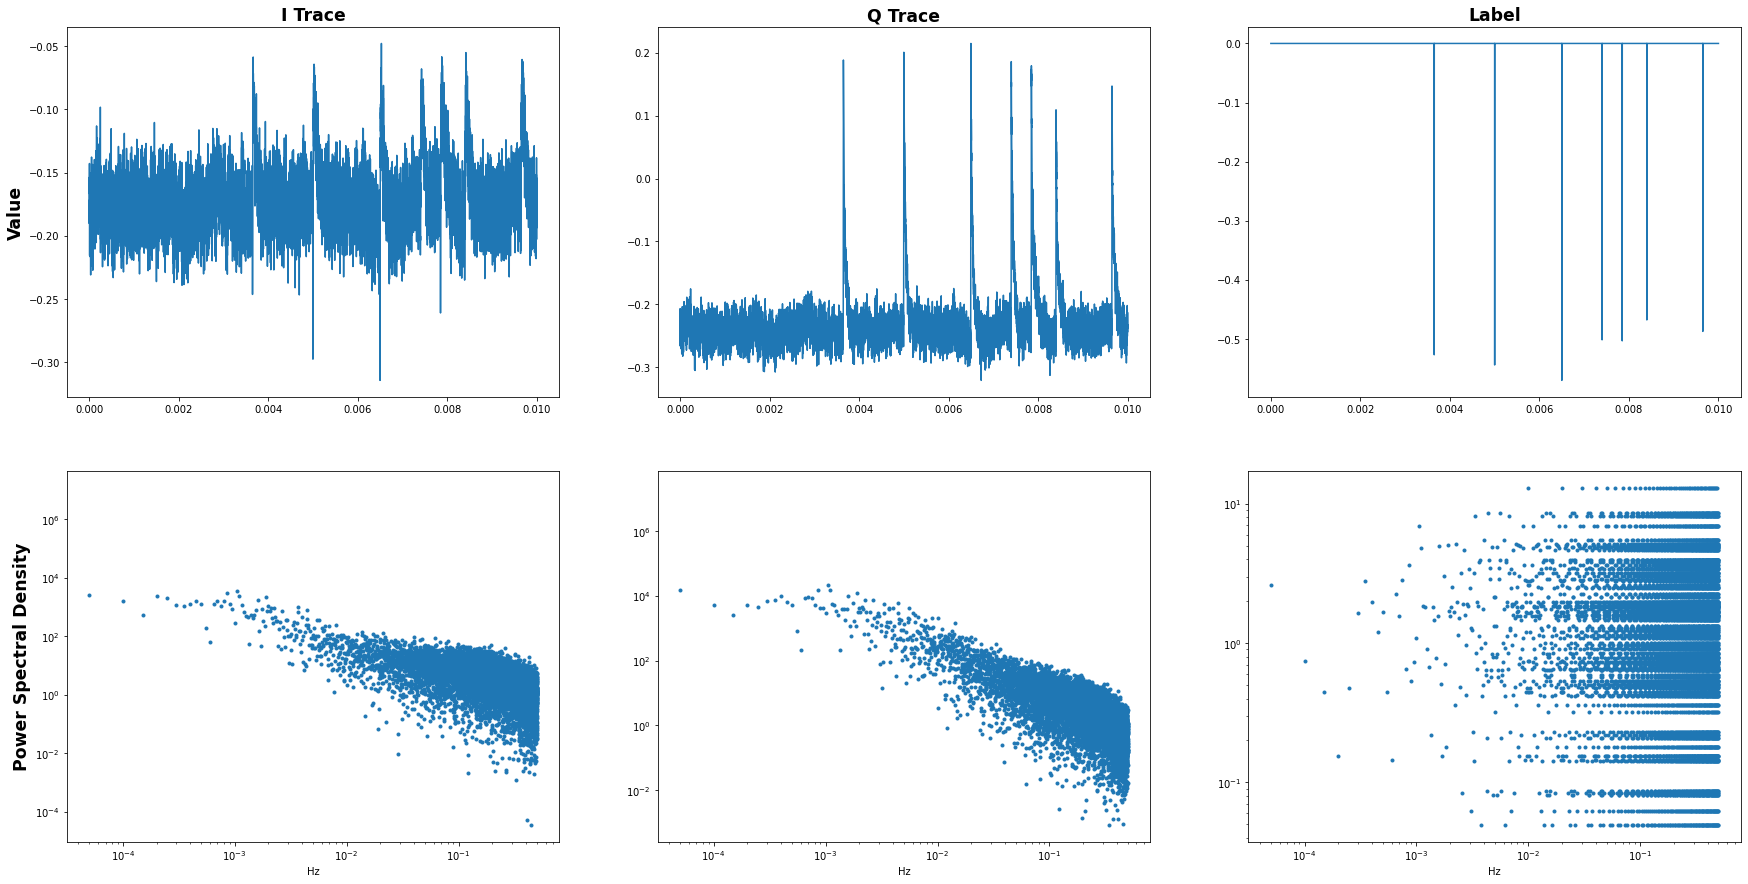

In [9]:
fig, ax = plt.subplots(2,3,figsize = (30,15))

photon_prob, photon_energy = label

#Fourier Transform stuff
freq = np.fft.fftfreq(len(time))
powerspec_i = np.abs(np.fft.fft(i_train))**2
powerspec_q = np.abs(np.fft.fft(q_train))**2
powerspec_label = np.abs(np.fft.fft(photon_energy))**2


#Row labels
ax[0,0].set_ylabel("Value",fontweight = "bold",size = 'xx-large', rotation = 90)
ax[1,0].set_ylabel("Power Spectral Density",fontweight = "bold",size = 'xx-large', rotation = 90)

#Column labels
ax[0,0].set_title("I Trace",fontweight = "bold", size = 'xx-large')
ax[0,1].set_title("Q Trace",fontweight = "bold", size = 'xx-large')
ax[0,2].set_title("Label",fontweight = "bold", size = 'xx-large')

#x_label + x_lims
for j in range(3):
    ax[1,j].set_xlabel("Hz")

#I_trace
ax[0,0].plot(time, i_train)
ax[1,0].loglog(freq,powerspec_i, linestyle = '', marker = '.')

#Q_trace
ax[0,1].plot(time, q_train)
ax[1,1].loglog(freq,powerspec_q, linestyle = '', marker = '.')

#Photon Energy
ax[0,2].plot(time,photon_energy)
ax[1,2].loglog(freq,powerspec_label, linestyle = '', marker = '.') #I don't think there's any physical meaning to be pulled from this plot

plt.show()

If there are no photons incident in the validation set (the last `1-split_fraction` datapoints in the dataset) then the early stopping callback may halt training early because validation loss isn't improving. To solve this problem, either increase `TrainingTime` so that the validation set will always contain incident photons - at the expense of computational time in training the model, or rerun the **Synthetic Generation** and **Synthetic Data and Power Spectral Density Visualization** cells to regenerate synthetic training data until the validation dataset contains incident photons.

# **Model Loading**

**Hyperparameters** <br>
Port hyperparameters used in training the model

In [10]:
num_past_time_steps = 50 #This hyperparameter describes how many datapoints into the past the model will look at when making predictions
num_future_time_steps = 100 #This hyperparameter describes how many datapoints into the future the model will look at when making predictions
batch_size = 100 #This hyperparameter describes how many Dataset slices the model will look at before adjusting model parameters
vector_size = 2 #this indicates the dimension of inputs to the model (currently dimensions of [I, Q])

**Custom Loss Function**

For a given range of 'true' values (a single batch of the label) this loss function backpropagates a single value. For each batch, we have five parameters we can use to describe how 'good' model predictions are. A weighted sum of these five parameters is the value returned by the `global_loss` function. 

&emsp; *Predicted Photon Count -*  $N_\gamma$ 

$$\begin{align}
N_\gamma =& \int P_\gamma  dt \\
N_\gamma =& \sum P_i\ \\
L(N_\gamma) =& (N - N_\gamma)^2
\end{align}$$
 

&emsp;  *Predicted Photon Energy -* $E_\gamma$

$$\begin{align}
E_\gamma =& \int E_\gamma P_\gamma  dt \\
E_\gamma =& \sum P_i E_i \\
L(E_\gamma) =& (E - E_\gamma)^2
\end{align}$$

&emsp;  *Variance in Predicted Energy -* $\sigma_E$

$$\begin{align}
\sigma_E =& \int (E - E_\gamma)^2 P_\gamma  dt \\
\sigma_E =& \sum (E - E_i)^2P_i \\
L(\sigma_E) =& (0 - \sigma_E)^2
\end{align}$$

&emsp;  *Predicted Photon Incidence Time -* $t_\gamma$

$$\begin{align}
t_\gamma =& \int t P_\gamma  dt \\
t_\gamma =& \sum t P_i \\
L(t_\gamma) =& (t_0 - t_\gamma)^2
\end{align}$$

&emsp;  *Variance in Predicted Time -* $\sigma_t$

$$\begin{align}
\sigma_t =& \int (t - t_\gamma)^2 P_\gamma dt \\
\sigma_t =& \sum (t - t_i)^2 P_i \\
L(\sigma_t) =& (0- \sigma_t)^2
\end{align}$$

&emsp;  *Global Loss Function*
$$L(N_\gamma, E_\gamma, \sigma_E, t_\gamma, \sigma_t) = \omega_0L(n_\gamma) + \omega_1L(E_\gamma) + \omega_2L(\sigma_E) + \omega_3L(t_\gamma) + \omega_4L(\sigma_t)$$


If the photon count is zero, then the loss from the photon count should be the only contribution to the global loss, and $\omega_1 = \omega_2 = \omega_3 =\omega_4 = 0$. Unfortunately, I could not figure out how to get the model to compile without erroring with a comparison infrastructure to determine when a photon is incident in the batch in order to set the weights to 0. The $i$th index refers to indices where photons are incident. $P_\gamma$ is the model's prediction of the probability at each batch index that a photon is incident, $E_\gamma$ is a prediction of the incident photon's energy, $t_\gamma$ is the model's prediction of the photon's incidence, and $t_0$ is the actual index at which the photon is incident. 




In [11]:
def global_loss(predicted_probability, predicted_energy, time, true_probability, true_energy):
    #from the input data, get everything to have a shape of [None, span] None is a placeholder in graph execution for batch_size
    predicted_probability = tf.cast(tf.squeeze(predicted_probability, axis = -1), tf.float32)
    predicted_energy = tf.cast(tf.squeeze(predicted_energy, axis = -1), tf.float32)
    t = tf.cast(time, tf.float32)
    true_energy = tf.cast(true_energy, tf.float32)
    true_probability = tf.cast(true_probability, tf.float32)

    #predicted photon count loss
    predicted_photon_count = tf.math.reduce_sum(predicted_probability)
    true_photon_count = tf.math.reduce_sum(true_probability)
    predicted_photon_count_loss = tf.math.square(predicted_photon_count - true_photon_count)

    #predicted photon energy loss
    predicted_photon_energy = tf.math.reduce_sum(tf.math.multiply(predicted_probability, predicted_energy))
    true_photon_energy = tf.math.reduce_sum(true_energy)
    predicted_photon_energy_loss = tf.math.square(predicted_photon_energy - true_photon_energy)

    #predicted energy variance loss
    predicted_energy_variance = tf.math.reduce_sum(tf.math.multiply(tf.math.square(tf.math.subtract(predicted_energy, predicted_photon_energy)), predicted_probability))
    true_energy_variance = tf.math.reduce_sum(tf.math.square(tf.math.subtract(true_energy, true_photon_energy)))
    predicted_energy_variance_loss = tf.square(predicted_energy_variance - true_energy_variance)

    #predicted photon incidence loss
    predicted_photon_incidence = tf.math.reduce_sum(tf.math.multiply(t, predicted_probability))
    true_photon_incidence = tf.math.reduce_sum(tf.math.multiply(t,true_probability))
    predicted_photon_incidence_loss = tf.math.square(predicted_photon_incidence - true_photon_incidence)

    #predicted time variance loss
    predicted_time_variance = tf.math.reduce_sum(tf.math.multiply(tf.math.square(tf.math.subtract(t, predicted_photon_incidence)), predicted_probability))
    true_time_variance = tf.math.reduce_sum(tf.math.multiply(tf.math.square(tf.math.subtract(t, true_photon_incidence)), true_probability))
    predicted_time_variance_loss = tf.math.square(predicted_time_variance - true_time_variance)

    #weighting
    photon_count_weight = tf.constant(1e0, dtype=tf.float32) * predicted_photon_count_loss
    photon_energy_weight = tf.constant(1e0, dtype=tf.float32) * predicted_photon_energy_loss
    energy_variance_weight = tf.constant(1e0, dtype=tf.float32) * predicted_energy_variance_loss
    photon_incidence_weight = tf.constant(1e0, dtype=tf.float32) * predicted_photon_incidence_loss
    time_variance_weight = tf.constant(1e0, dtype=tf.float32) * predicted_time_variance_loss

    
    #returning loss differently based on whether a photon is in the batch 
    global_loss = tf.cond(
            pred = tf.math.equal(true_photon_count, tf.constant(0., dtype = tf.float32)),
            true_fn = lambda: photon_count_weight,
            false_fn = lambda: photon_count_weight + photon_energy_weight + energy_variance_weight + photon_incidence_weight + time_variance_weight
        )

    return global_loss

**Defining Custom Metrics**

In [12]:
class Batch_Average(tf.keras.metrics.Metric):
    #initializing the metric class
    def __init__(self):
        super(Batch_Average,self).__init__()
        self.batch_average = self.add_weight(name='avg', initializer = 'zeros') #weight is an updatable, dynamic variable in tensorflow
        self.tot_loss = self.add_weight(name = 'tot',initializer = 'zeros')
        self.num_batches = self.add_weight(name = 'batch',initializer = 'zeros')

    #update the state at the end of each batch
    def update_state(self, loss):
        self.num_batches.assign_add(1)
        self.tot_loss.assign_add(loss)
        self.batch_average.assign(self.tot_loss/self.num_batches)
    
    #what the metric displays
    def result(self):
        return self.batch_average
    
    #The state of the metric will be reset at the start of each epoch.
    def reset_state(self):
        self.batch_average.assign(0.)
        self.tot_loss.assign(0.)
        self.num_batches.assign(0.)


#defining model metrics outside the class because that's what they did in the tensorflow documentation
avg_loss_train = Batch_Average()
avg_loss_val = Batch_Average()


**Model Subclassing**

In [13]:
class Photon_Prediction(tf.keras.Model):
    #initialize the model class
    def __init__(self, probability, energy):
        super(Photon_Prediction,self).__init__()
        self.probability = probability
        self.energy = energy

    #define the outputs from the model
    def call(self, inputs, training): 
        probability_prediction = self.probability(inputs, training) 
        energy_prediction = self.energy(inputs, training)
        photon_prediction = tf.math.multiply(probability_prediction, energy_prediction)
        return photon_prediction

    #outlines the optimizer(s) to be used (and loss function if I wasn't using a custom loss function)
    def compile(self, optimizer): 
        super(Photon_Prediction, self).compile()
        self.optimizer = optimizer     

    #custom training routine
    @tf.function
    def train_step(self, Dataset):
        #unbatch the targets and training data to act on them separately in the loss function
        training_data, time, probability_target, energy_target  = Dataset

        #train both the energy and probability predictions together so that both predictions can be used simultaneously
        with tf.GradientTape(persistent = True) as tape:
            #generate energy and probability predictions
            probability_prediction = self.probability(training_data, training = True)
            energy_prediction = self.energy(training_data, training = True)

            #acquire a loss value from the custom loss function
            loss = global_loss(probability_prediction, energy_prediction, time, probability_target, energy_target)

        #apply gradients to the probability sequential model weights
        grads = tape.gradient(loss, self.probability.trainable_weights)
        self.optimizer.apply_gradients(
            zip(grads, self.probability.trainable_weights)
        )

        #apply gradients for the energy sequential model weights
        grads = tape.gradient(loss, self.energy.trainable_weights)
        self.optimizer.apply_gradients(
            zip(grads, self.probability.trainable_weights)
        )

        #Compute the custom metrics
        avg_loss_train.update_state(loss)

        return {"I II II L": avg_loss_train.result()}
    
    #define a validation step
    @tf.function
    def test_step(self, Dataset):
        #unbatch the targets and training data to act on them separately in the loss function
        validation_data, time, probability_target, energy_target = Dataset

        #generate energy and probability predictions
        probability_prediction = self.probability(validation_data, training = False)
        energy_prediction = self.energy(validation_data, training = False)

        #acquire a loss value from the custom loss function
        loss = global_loss(probability_prediction, energy_prediction, time, probability_target, energy_target)

        #Compute the custom metrics
        avg_loss_val.update_state(loss)

        return {"loss": avg_loss_val.result()}

    #Metric Objects are listed here so that reset_states() is called automatically at the start of each epoch
    @property
    def metrics(self):
        return [avg_loss_train, avg_loss_val]

**Blank Model Creation**

In [14]:
def create_model():
    #input shape
    explicit_input_shape = (None, vector_size, num_past_time_steps + 1 + num_future_time_steps)
    implicit_input_shape = (vector_size, num_past_time_steps + 1 + num_future_time_steps)

    #create the probability prediction
    probability = tf.keras.Sequential(
    [
        #Input Layer
        tf.keras.Input(shape = implicit_input_shape),
     
        #Convolutional Network
        tf.keras.layers.Conv1D(filters = 128, kernel_size = 5, strides = 1, padding = 'same',activation = 'gelu'),
        tf.keras.layers.MaxPooling1D(pool_size = 2, padding = 'same', data_format = 'channels_last'),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv1D(filters = 64, kernel_size = 5, strides = 1, padding = 'same',activation = 'gelu'),
        tf.keras.layers.MaxPooling1D(pool_size = 2, padding = 'same', data_format = 'channels_last'),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv1D(filters = 32, kernel_size = 5, strides = 1, padding = 'same',activation = 'gelu'),
        tf.keras.layers.MaxPooling1D(pool_size = 5, padding = 'same', data_format = 'channels_last'),
        tf.keras.layers.BatchNormalization(),
        
        #LSTM Network
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences = True)),
        tf.keras.layers.BatchNormalization(),
     
        #Dense Layer
        tf.keras.layers.Dense(32, activation = 'gelu'),
        tf.keras.layers.BatchNormalization(),
      
        #Output Layer (Sigmoid activation forces a value between 0 and 1) + Flattening
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])

    #create the energy prediction
    energy = tf.keras.Sequential(
    [
        #Input Layer
        tf.keras.Input(shape = implicit_input_shape),
        
        #Convolutional Network
        tf.keras.layers.Conv1D(filters = 128, kernel_size = 5, strides = 1, padding = 'same',activation = 'gelu'),
        tf.keras.layers.MaxPooling1D(pool_size = 2, padding = 'same', data_format = 'channels_last'),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv1D(filters = 64, kernel_size = 5, strides = 1, padding = 'same',activation = 'gelu'),
        tf.keras.layers.MaxPooling1D(pool_size = 2, padding = 'same', data_format = 'channels_last'),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv1D(filters = 32, kernel_size = 5, strides = 1, padding = 'same',activation = 'gelu'),
        tf.keras.layers.MaxPooling1D(pool_size = 5, padding = 'same', data_format = 'channels_last'),
        tf.keras.layers.BatchNormalization(),
        
        #LSTM Network
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences = True)),
        tf.keras.layers.BatchNormalization(),
     
        #Dense Layer
        tf.keras.layers.Dense(32, activation = 'gelu'),
        tf.keras.layers.BatchNormalization(),

        #Output Layer + Flattening
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1)
    ])
    
    #Use the class to instantiate the model
    model = Photon_Prediction(probability = probability, energy = energy)
    
    #compile the model with the optimizer
    model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    )

    #building model into a layer DAG so that weights can be loaded
    model.build(explicit_input_shape)

    return model


**Loading Weights**

In [15]:
modeldir = datadir + 'Saved Models/Model 8/'
model = create_model()
model.load_weights(modeldir + "saved_model.h5")
model.summary()

Model: "photon__prediction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 1)                 252321    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 252321    
                                                                 
Total params: 504,642
Trainable params: 502,722
Non-trainable params: 1,920
_________________________________________________________________


**Displaying Training Metrics**

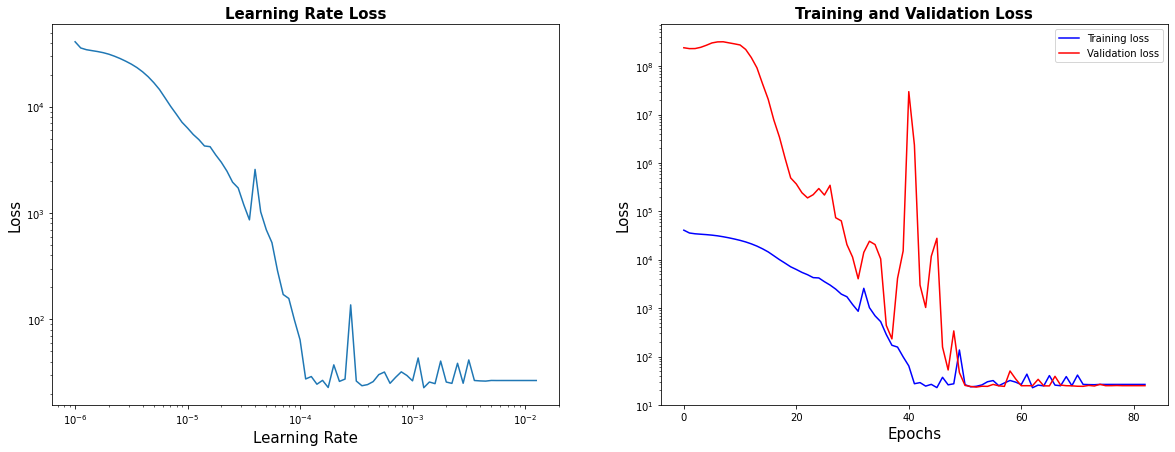

In [16]:
history = np.load(modeldir + "my_history.npy", allow_pickle = True).item()
fig, ax = plt.subplots(1,2, figsize = (20,7))


#display Loss as a function of Learning Rate
ax[0].loglog(history["lr"], history["I II II L"])
ax[0].set_xlabel("Learning Rate", fontsize = 15)
ax[0].set_title("Learning Rate Loss", fontsize = 15, fontweight = 'bold')
ax[0].set_ylabel("Loss", fontsize = 15)


#Display Loss as a function of epochs
loss = history["I II II L"]
val_loss = history["val_loss"]
epochs = range(len(loss))
ax[1].semilogy(epochs, loss, c="b", label="Training loss")
ax[1].semilogy(epochs, val_loss,c="r", label="Validation loss")
ax[1].set_title("Training and Validation Loss", fontsize = 15, fontweight = 'bold')
ax[1].set_xlabel("Epochs", fontsize = 15)
ax[1].set_ylabel("Loss", fontsize = 15)
ax[1].legend()
plt.show()

# **Model Evaluation**

**Defining Data Processing Functions** <br>
For consistency,  we need to create the evaluation data the same way we create the training data, which means we must redefine the functions utilized to process synthetic data in the old notebook

In [17]:
def normalize(data):
  mean = np.mean(data)
  std = np.std(data)
  return (data-mean)/(std)

def make_windows(input_array, num_prev_time_steps, num_future_time_steps):
    #identifying the span of each window in terms of given parameters
    span = num_prev_time_steps + 1 + num_future_time_steps #the +1 is for the present time step for which the window is centered around
    
    #if input_array is 1D
    if len(input_array.shape) == 1:
        #getting parameters from the shape of the input array
        length = len(input_array)
        num_windows = length - (span - 1) #the -1 is to account for the present time step for which the window is centered around

        #initializing windows with correct shape
        windows = np.zeros(shape = (span, num_windows))
    
        #filling windows with values from the array
        for i in range(num_windows):
            windows[:,i] = input_array[i:span+i]
    
    #otherwise (which really just means 2D because this isn't able to compensate for 3D or higher input_arrays)
    else:
        #getting parameters from the shape of the input array
        length, height = input_array.shape
        num_windows = length - (span - 1) #the -1 is to account for the present time step for which the window is centered around
    
        #initializing windows with correct shape
        windows = np.zeros(shape = (span, height, num_windows))
    
        #filling windows with values from the array
        for i in range(num_windows):
            windows[:,:,i] = input_array[i:span+i]
    
    #Dataset_from_tensor_slices consumes the first dimension, so we should transpose the windows so the first axis is the axis of windows
    windows = np.transpose(windows)
  
    return windows

def make_Dataset(batch_size, num_prev_time_steps, num_future_time_steps, I, Q, time = None, label = None):
    #only normalize the input data so the target output doesn't get warped
    I = normalize(I)
    Q = normalize(Q)

    #creating array from which to make windows
    input_data = np.zeros(shape=(I.size,2))
    input_data[:,0] = I
    input_data[:,1] = Q

    #creating windows for the data
    data_windows = tf.convert_to_tensor(make_windows(input_data, num_prev_time_steps, num_future_time_steps), dtype = tf.float32)

    #using optional argument to build Datasets with/without labels & time if they are/aren't passed
    if label is None and time is None:
        dataset = tf.data.Dataset.from_tensor_slices(data_windows)
    else:
        #converting label + time to tensors
        probability_label = tf.convert_to_tensor(label[0][num_prev_time_steps:-num_future_time_steps], dtype = tf.float32)
        energy_label = tf.convert_to_tensor(label[1][num_prev_time_steps:-num_future_time_steps], dtype = tf.float32)
        time = tf.convert_to_tensor(time[num_prev_time_steps:-num_future_time_steps], dtype = tf.float32)

        #constructing dataset tuple
        dataset = tf.data.Dataset.from_tensor_slices((data_windows, time, probability_label, energy_label))
    
    #batching datasets
    dataset = dataset.batch(batch_size)

    return dataset


**Defining `model_predictions` Function**<br>
The `model_predictions` function generates evaluation data using the `synthetic_data_gen` function defined under the **Data Generation** heading. It then generates and returns model predictions based on the evaluation data generated in the function call. 

In [18]:
def model_predictions(model, i_trace,q_trace, filtered_data, peak_indices, SampRate, TrainingTime, PhotonRate, n_pts, pulse_halfwidth, return_labels = bool):
    #generating evaluation data
    i_eval, q_eval, label_eval = synthetic_data_gen(i_trace, q_trace, filtered_data, peak_indices, SampRate, TrainingTime, PhotonRate, n_pts, pulse_halfwidth,return_labels=True)
    N_time_datapoints = int(SampRate*TrainingTime)
    time_eval = np.linspace(0,TrainingTime,N_time_datapoints)

    #Need to create the evaluation data the same way as the training data, using previously defined functions
    dataset_eval = make_Dataset(batch_size, num_past_time_steps, num_future_time_steps, i_eval, q_eval, None, None)

    #Generating Model Predictions
    output = model.predict(dataset_eval)

    #the 1 dimensional model prediction is at each index the predicted energy of a photon multiplied by the probability that there is indeed a photon incident
    model_prediction = np.squeeze(output)

    if return_labels == True:
        return model_prediction, label_eval
    elif return_labels == False:
        return model_prediction        

**Generating a Rescaling Factor**<br>
Model predictions need to be rescaled by a constant factor in order to be compared to label peaks. This `rescaling_factor` can be estimated by eye, but ideally, we want to determine the rescaling factor quantitatively for any set of data that the model might be asked to make predictions upon. In the next code cell, we generate evaluation data and minimize the `scaling_factor` function(which returns the least squares difference between the model's predicted peaks and the label's peaks) to obtain the best fit `rescaling_factor`. We then perform bootstrap resampling by redoing the previous step multiple times in order to recover a bootstrapped `rescaling_factor` and it's uncertainty. This bootstrapped resampled `rescaling_factor` can then be applied to all predictions made by the model. Expect this cell to take around 10 minutes to run with 50 iterations.

In [19]:
#Defining the function to minimize to obtain the scaling factor for each generated evaluation dataset
def scaling_factor(rescaling_factor, model_prediction, label_eval):
    #We want to determine the appropriate scaling factor by minimizing the least squares difference of the model and label peaks
    peak_indices = np.where(label_eval != 0)
    label_peaks = label_eval[peak_indices]
    model_peaks = model_prediction[peak_indices]

    #calculate lstsq value(to be minimized)
    lstsq =  np.sum(model_peaks*rescaling_factor - label_peaks)**2

    return lstsq

def find_best_rescaling_factor(model_prediction, label_eval):
    guess = np.random.rand() #Since we only have one parameter, our initial guess shouldn't matter
    rescaling_factor = minimize(scaling_factor, guess, args=(model_prediction, label_eval), method = "Powell").x
    return rescaling_factor

eval_TrainingTime = 0.01 #even if training the model on more than 0.01 second of training time, evaluate it on 0.01 second of traing time because it's faster
N_time_datapoints = int(SampRate*eval_TrainingTime)
time_eval = np.linspace(0,TrainingTime,N_time_datapoints)

#Performing bootstrap resampling: When generating synthetic data with a training time of 0.01 seconds, model_predictions took about 10 seconds per iteration(expect this cell to be computationally expensive)
num_iter = 50
bstrap_list = []
for i in range(num_iter):
    bstrap_model_prediction, bstrap_label = model_predictions(model, i_trace,q_trace, filtered_data, peak_indices, SampRate, eval_TrainingTime, PhotonRate, n_pts, pulse_halfwidth, return_labels = True)
    rescaling_factor_i = find_best_rescaling_factor(bstrap_model_prediction, bstrap_label[1])
    bstrap_list.append(rescaling_factor_i)

bstrap_rescaling_factor = np.mean(bstrap_list)
sigma_rescaling_factor = np.std(bstrap_list)

print(f"Using bootstrap resampling with {num_iter} iterations generates a rescaling factor of {bstrap_rescaling_factor:.3f} ± {sigma_rescaling_factor:.3f}")

199/199 [==============================] - 2s 11ms/step
Using bootstrap resampling with 50 iterations generates a rescaling factor of -294.177 ± 5610.627


A small range of rescaling factors from multiple iterations of model predictions on randomly created evaluation data during bootstrapping implies that the model is consistently 'off' the true values by roughly the same amount. This corresponds to the uncertainty on the bootstrap resampled rescaling factor, which therefore gives an indication of how precise (and therefore how good) the model is.

**Model Prediction + Scaling Factor Generation**

In [20]:
prediction, label_eval = model_predictions(model, i_trace,q_trace, filtered_data, peak_indices, SampRate, eval_TrainingTime, PhotonRate, n_pts, pulse_halfwidth, return_labels = True)
energy_eval = label_eval[1]
prediction = prediction - np.mean(prediction)
best_rescaling_factor = find_best_rescaling_factor(prediction, energy_eval)

199/199 [==============================] - 2s 11ms/step


**Prediction Visualization**

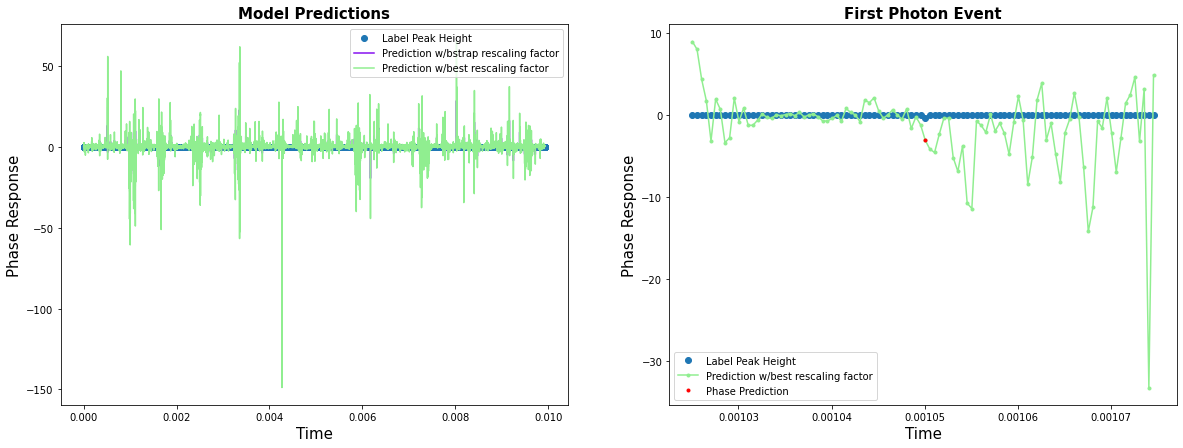

In [21]:
fig, ax = plt.subplots(1,2, figsize = (20,7))

#Plotting Model Predictions
ax[0].plot(time_eval[0:N_time_datapoints - (num_future_time_steps + num_past_time_steps)],energy_eval[0:N_time_datapoints - (num_future_time_steps + num_past_time_steps)],label = "Label Peak Height", linestyle = '', marker= 'o')
ax[0].plot(time_eval[0:N_time_datapoints - (num_future_time_steps + num_past_time_steps)],prediction[0:N_time_datapoints - (num_future_time_steps + num_past_time_steps)]*bstrap_rescaling_factor,label = "Prediction w/bstrap rescaling factor", c = '#850ef0')
ax[0].plot(time_eval[0:N_time_datapoints - (num_future_time_steps + num_past_time_steps)],prediction[0:N_time_datapoints - (num_future_time_steps + num_past_time_steps)]*best_rescaling_factor,label = "Prediction w/best rescaling factor", c = 'lightgreen')
ax[0].set_ylabel("Phase Response", fontsize = 15)
ax[0].set_xlabel("Time", fontsize = 15)
ax[0].set_title("Model Predictions", fontweight = 'bold', fontsize = 15)
ax[0].legend(loc = 'upper right')

#Zooming in on the first Photon Detection
first_photon = np.where(energy_eval != 0)[0][0] #gets index of first photon detection
ax[1].plot(time_eval[first_photon - 50:first_photon + 50],energy_eval[first_photon - 50:first_photon + 50],label = "Label Peak Height", linestyle = '', marker= 'o')
ax[1].plot(time_eval[first_photon - 50:first_photon + 50],prediction[first_photon - 50:first_photon + 50]*best_rescaling_factor,marker = '.',label = "Prediction w/best rescaling factor", c = 'lightgreen')
ax[1].plot(time_eval[first_photon], prediction[first_photon]*best_rescaling_factor, label = "Phase Prediction", linestyle = '', marker = '.', color = 'red')
ax[1].set_ylabel("Phase Response", fontsize = 15)
ax[1].set_xlabel("Time", fontsize = 15)
ax[1].set_title("First Photon Event", fontweight = 'bold', fontsize = 15)
ax[1].legend()

plt.show()
